# **Personal Key Indicators of Heart Disease**
### Analysis of 2020 annual CDC survey data of 400k adults related to their health status
##### Table of contents
1. Set-up
2. General data information
3. Demographic analysis
4. Preprocessing
5. Correlation analysis
6. Helper functions
7. Create logistic regression model
8. Tune logistic regression model
9. Logistic regression model metrics
10. Create decision tree model
11. Tune decision tree model
12. Decision tree model metrics

##### Set-up

In [50]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay, 
    RocCurveDisplay, 
    PrecisionRecallDisplay, 
    roc_auc_score,
    precision_recall_curve,
    recall_score,
    precision_score,
    accuracy_score,
    f1_score
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 

from imblearn.over_sampling import SMOTE

In [51]:
# Load data
data = pd.read_csv("data/heart_2020_cleaned.csv")


##### General data information

In [52]:
# Preview data
data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [53]:
# General data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

##### Demographic analysis

In [54]:
# Check for imbalance in heart disease diagnosis
data["HeartDisease"].value_counts(normalize=True).round(2)

No     0.91
Yes    0.09
Name: HeartDisease, dtype: float64

The variable we are trying to predict is imbalanced. We might need to consider techniques to resample the data.

In [55]:
# Check for imbalance in sex
data["Sex"].value_counts(normalize=True).round(2)

Female    0.52
Male      0.48
Name: Sex, dtype: float64

In [56]:
# Check for imbalance in race
data["Race"].value_counts(normalize=True).round(2)

White                             0.77
Hispanic                          0.09
Black                             0.07
Other                             0.03
Asian                             0.03
American Indian/Alaskan Native    0.02
Name: Race, dtype: float64

The population is mostly white.

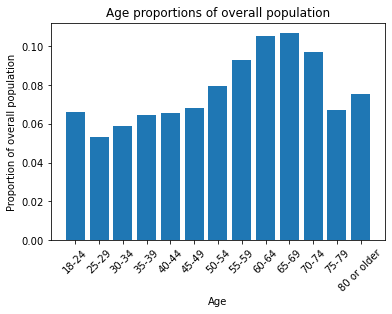

In [57]:
# Plot age distribution
age_categories = data["AgeCategory"].sort_values().unique()
age_proportions = data["AgeCategory"].value_counts(normalize=True).sort_index()

plt.bar(x=age_categories, height=age_proportions)
plt.title("Age proportions of overall population")
plt.xlabel("Age")
plt.xticks(rotation = 45)
plt.ylabel("Proportion of overall population")
plt.show()

The age distribution of the population appears to skew older.

##### Preprocessing

We will now create our features for predicting heart disease.

In [58]:
# Convert column values to categories
category_columns = ["Sex", "AgeCategory", "Race", "GenHealth"]
for column in category_columns:
    data[column] = data[column].astype("category")

# Create indicator columns
data = pd.get_dummies(data, columns=category_columns)

# Clean possible boolean columns
boolean_columns = [
    "HeartDisease",
    "Smoking",
    "AlcoholDrinking",
    "Stroke",
    "DiffWalking", 
    "Diabetic",
    "PhysicalActivity",
    "Asthma",
    "KidneyDisease",
    "SkinCancer"
]
for column in boolean_columns:
    # Replace sub-strings with True or False based off response
    data.loc[data[column].str.contains("yes", case=False, na=False), column] = True
    data.loc[data[column].str.contains("no", case=False, na=False), column] = False

    # Ensure type is boolean
    data[column] = data[column].astype(bool)

# Split BMI into categories
data["BMI_Underweight"] = data["BMI"] < 18.5
data["BMI_Normal"] = data["BMI"].between(18.5, 25, inclusive="left")
data["BMI_Overweight"] = data["BMI"].between(25, 30, inclusive="left")
data["BMI_Obese"] = data["BMI"] >= 30

# Drop original BMI column
data = data.drop(columns=["BMI"])

After creating our features, we will now create training, validation, and test data sets necessary to assess how well our models generalize to new data.

In [59]:
# Features used to predict response
X = data.drop(columns=["HeartDisease"])

# Variable we want to predict
y = data["HeartDisease"]

# Split data into training, testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# Standardize features used to predict response
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(X_valid)

##### Correlation analysis

We will now perform correlation analysis to check if any feature is strongly correlated to heart disease. We will also see if we can remove any predictive feature that is strongly correlated to another predictive feature.

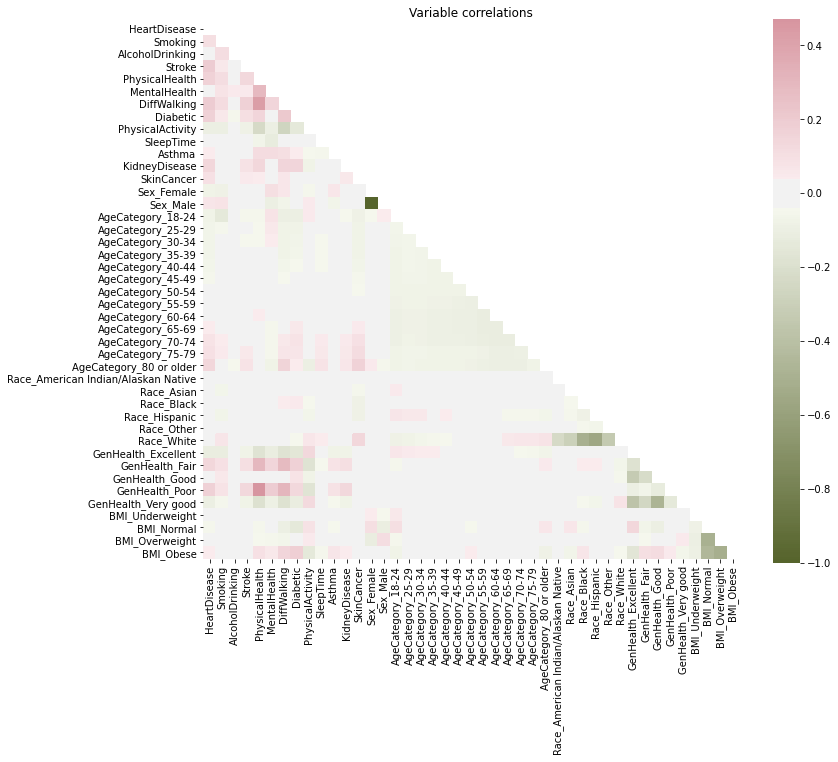

In [60]:
# Create a table of variable correlations
training_data = pd.concat([y_train, X_train], axis=1)
corr =  training_data.corr()

# Create a mask
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(
    100, 7, s=75, l=40, n=5, center="light", as_cmap=True
)

# Plot heat map of variable correlations
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr, 
    mask=mask, 
    center=0, 
    fmt='.2f',
    square=True, 
    cmap=cmap,
)
plt.title("Variable correlations")
plt.show()

No feature seems to be very strongly correlated to heart disease. We do see that the sex category features are very strongly correlated. Because the sex category features essentially convey the same information, we can choose to remove one of them.

In [61]:
# Drop redundant features
X_train = X_train.drop(columns=["Sex_Female"])

##### Helper functions

This section contains all relevant helper functions for visualizing various metrics.

In [62]:
def plot_confusion_matrix_from_estimator(
    estimator: BaseEstimator, 
    X: np.ndarray, 
    y: np.ndarray, 
    normalize: str = None
) -> None:
    """Plot confusion matrix for a given model using a fitted estimator."""
    # Create confusion matrix object
    confusion_matrix = ConfusionMatrixDisplay.from_estimator(
        estimator,
        X,
        y,
        cmap=plt.cm.Blues,
        normalize=normalize,
        colorbar=False
    )

    # Set title
    confusion_matrix.ax_.set_title("Confusion matrix of heart disease predictions")

    # Show plot
    plt.show()

In [63]:
def plot_confusion_matrix_from_predictions(
    y_true: np.ndarray, 
    predictions: np.ndarray, 
    normalize: str = None
) -> None:
    """Plot confusion matrix for a given model using predictions."""
    # Create confusion matrix object
    confusion_matrix = ConfusionMatrixDisplay.from_predictions(
        y_true,
        predictions,
        cmap=plt.cm.Blues,
        normalize=normalize,
        colorbar=False
    )

    # Set title
    confusion_matrix.ax_.set_title("Confusion matrix of heart disease predictions")

    # Show plot
    plt.show()

In [64]:
def plot_roc_curve_from_estimator(estimator: BaseEstimator, X: np.ndarray, y: np.ndarray) -> None:
    """Plot ROC curve for a given model using a fitted estimator."""
    # Create ROC curve display object
    display = RocCurveDisplay.from_estimator(estimator, X, y)

    # Change line color of ROC curve to orange
    display.line_.set_color("orange")
    display.ax_.get_legend().legendHandles[0].set_color("orange")

    # Create base line of a random classifier
    display.ax_.plot([0, 1], [0, 1], linestyle="--", color="blue")

    # Add title
    display.ax_.set_title("ROC curve")

    # Show plot
    plt.show()

In [65]:
def plot_roc_curve_from_predictions(
    y_true: np.ndarray, 
    predictions: np.ndarray, 
) -> None:
    """Plot ROC curve for a given model using predictions."""
    # Create ROC curve display object
    display = RocCurveDisplay.from_predictions(y_true, predictions)

    # Change line color of ROC curve to orange
    display.line_.set_color("orange")
    display.ax_.get_legend().legendHandles[0].set_color("orange")

    # Create base line of a random classifier
    display.ax_.plot([0, 1], [0, 1], linestyle="--", color="blue")

    # Add title
    display.ax_.set_title("ROC curve")

    # Show plot
    plt.show()

In [66]:
def plot_pr_curve_from_estimator(
    estimator: BaseEstimator, 
    X: np.ndarray, 
    y: np.ndarray, 
) -> None:
    """Plot PR curve for a given model using predictions."""
    # Create PR display
    display = PrecisionRecallDisplay.from_estimator(estimator=estimator, X=X, y=y)

    # Set title
    _ = display.ax_.set_title("PR curve")

In [67]:
def plot_pr_curve_from_predictions(
    y_true: np.ndarray, 
    predictions: np.ndarray, 
) -> None:
    """Plot PR curve for a given model using predictions."""
    # Create PR display
    display = PrecisionRecallDisplay.from_predictions(
        y_true=y_true, y_pred=predictions
    )

    # Set title
    _ = display.ax_.set_title("PR curve")


In [68]:
def plot_decision_tree_roc_auc(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_test: pd.DataFrame,
    parameter_name: str,
    parameter_values: list,
) -> None:
    """Plot decision tree ROC AUC score with varying parameters."""
    # Initialize lists to store ROC AUC scores
    train_results = []
    test_results = []

    for parameter_value in parameter_values:
        # Create decision tree classifier with a given parameter
        dtc = DecisionTreeClassifier(**{parameter_name: parameter_value})

        # Fit model with training data
        fitted_dtc = dtc.fit(X_train, y_train)

        # Calculate ROC AUC score with training data
        train_score = roc_auc_score(y_train, fitted_dtc.predict_proba(X_train)[:, 1])

        # Add score to training data results
        train_results.append(train_score)

        # Calculate ROC AUC score with test data
        test_score = roc_auc_score(y_test, fitted_dtc.predict_proba(X_test)[:, 1])

        # Add score to training data results
        test_results.append(test_score)

    # Create plot to compare results
    plt.plot(parameter_values, train_results, label="Training data AUC score")
    plt.plot(parameter_values, test_results, label="Test data AUC score")
    plt.ylabel("ROC AUC score")
    plt.xlabel(f"Parameter tested: {parameter_name}")
    plt.legend()
    plt.show()

In [69]:
def plot_precision_recall_vs_threshold(estimator: BaseEstimator, X: np.ndarray, y: np.ndarray) -> None:
    """Plot precision and recall with varying thresholds."""
    # Get positive class probabilities
    positive_class_probabilities = estimator.predict_proba(X)[:, 1]

    # Get precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(
        y_true=y, probas_pred=positive_class_probabilities
    )

    # Create plot
    plt.plot(thresholds, precision[:-1], "b", label="Precision")
    plt.plot(thresholds, recall[:-1], "g", label="Recall")

    # Create x-axis label
    plt.xlabel("Threshold")

    # Create legend
    plt.legend()

    # Set bounds for y-axis
    plt.ylim([0, 1])

    # Show plot
    plt.show()

In [70]:
def label_coefficients(coefficients: np.ndarray, X: np.ndarray) -> pd.Series:
    """Label coefficient values from model."""
    return pd.Series(
        {feature: coefficient for coefficient, feature in zip(coefficients, X.columns)}
    ).sort_values(ascending=False)

##### Create logistic regression model

In [71]:
# Create logistic regression
lr = LogisticRegression(max_iter=200)

##### Tuning logistic regression model

We will fit our logistic regression to the training data and check its performance.

In [72]:
# Fit logistic regression to training data
fitted_lr = lr.fit(X_train_scaled, y_train)

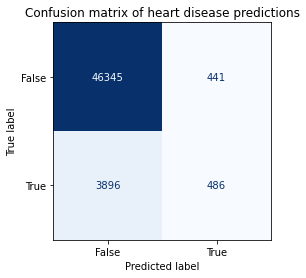

In [73]:
# Create confusion matrix of logistic regression predictions
plot_confusion_matrix_from_estimator(
    estimator=fitted_lr,
    X=X_valid_scaled, 
    y=y_valid,
    normalize=None
)

The above confusion matrix shows that the model is not very good at predicting heart disease. Nearly 89% of individuals with history of heart disease in the validation data set were mislabeled as individuals with no history of heart disease.

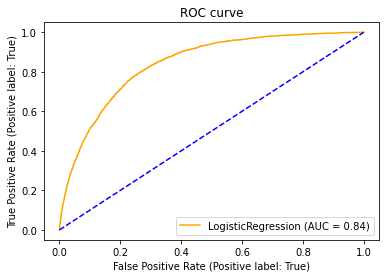

In [74]:
# Plot ROC curve of logistic regression
plot_roc_curve_from_estimator(
    estimator=fitted_lr,
    X=X_valid_scaled, 
    y=y_valid
)

Let's analyze the above ROC curve with the assistance of our confusion matrix. 

$FPR$ (false positive rate) and $TPR$ (true positive rate) are defined as follows: 

* $FPR = \frac{FP}{FP + TN}$ 

* $TPR = \frac{TP}{TP + FN}$

where $FP$ are false positives, $TN$ are true negatives, and $FN$ are false negatives.

Let's calculate the $FPR$ and $TPR$ based off the values in our confusion matrix.

$FPR = \frac{441}{441+46345} = 0.009$

$TPR = \frac{486}{486+3896} = 0.111$

We can see the $FPR$ is low because of the overwhelming number of $TN$. However, our $TPR$ is also low. Nearly 89% of the predictions for history of heart disease were incorrect.

The ROC AUC score provides an aggregate measure of performance across all possible decision threshold values. Our logistic regression model, by default, uses a decision threshold value of 0.5. This means that given the probabilities of an individual having history of heart disease, the model will classify the patient as having a history of heart disease if the probability is equal to or over 0.5. Let's plot the ROC curve again and mark the $FPR$ and $TPR$ calculated above.

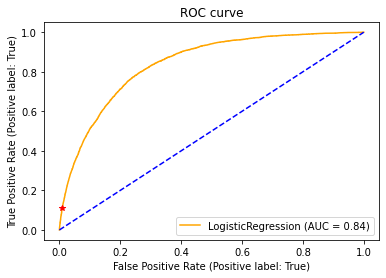

In [75]:
# Create ROC curve display object
display = RocCurveDisplay.from_estimator(fitted_lr, X_valid_scaled, y_valid)

# Change line color of ROC curve to orange
display.line_.set_color("orange")
display.ax_.get_legend().legendHandles[0].set_color("orange")

# Create base line of a random classifier
display.ax_.plot([0, 1], [0, 1], linestyle="--", color="blue")

# Create a marker
plt.plot(0.009, 0.111, "r*")

# Add title
display.ax_.set_title("ROC curve")

# Show plot
plt.show()

The red star represents our logistic regression model's $FPR$ and $TPR$ at the default decision threshold value of 0.5. If we were to decrease the decision threshold value, the $TPR$ would increase, but $FPR$ would also increase. Choosing an ideal decision threshold depends on the problem we are attempting to solve. Decreasing the decision threshold value could risk higher incorrect classification of individuals having no history of heart disease. However, decreasing the decision threshold value could also more accurately classify individuals who have history of heart disease.

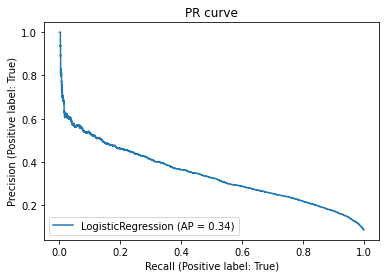

In [76]:
# Plot PR curve of logistic regression
plot_pr_curve_from_estimator(
    estimator=fitted_lr,
    X=X_valid_scaled, 
    y=y_valid
)

Let's analyze the PR curve with the assistance of our confusion matrix.

Precision and recall (also known as $TPR$) are defined as follows: 

* $Precision = \frac{TP}{TP + FP}$ 

* $Recall$ $(TPR) = \frac{TP}{TP + FN}$

Let's calculate precision and recall based off the values in our confusion matrix.

$Precision = \frac{486}{486+441} = 0.524$

$Recall = \frac{486}{486+3896} = 0.111$

Because precision and recall do not account for true negatives, we can better examine how the model performs in predicting the positive class.

As we saw in the above analysis, the model's recall ($TPR$) is poor; the model could only correctly classify 11% of all individuals with history of heart disease. The model has middling precision; of the model's classifications for individuals with history of heart disease, only roughly half were correct. Let's plot the PR curve again and mark the precision and recall calculated above.

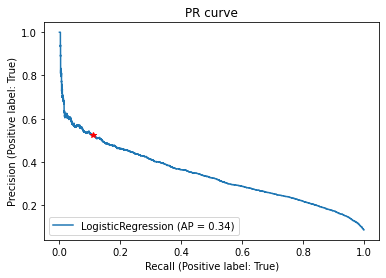

In [77]:
# Create PR display
display = PrecisionRecallDisplay.from_estimator(estimator=fitted_lr, X=X_valid_scaled, y=y_valid)

# Set title
_ = display.ax_.set_title("PR curve")

# Create a marker
plt.plot(0.111, 0.524, "r*")

plt.show()

The red star represents our logistic regression model's precision and recall at the default decision threshold value of 0.5. If we decrease the decision threshold value, we decrease the model's precision but increase the model's recall. If we are interested in more accurately classifying individuals with history of heart disease, we might want to prioritize increasing our model's recall. This does come at the risk of incorrectly classifying more individuals with no history of heart disease, however.

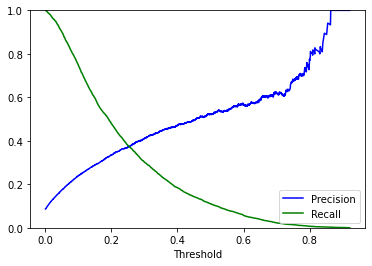

In [78]:
# Plot precision and recall with varying thresholds
plot_precision_recall_vs_threshold(estimator=fitted_lr, X=X_valid_scaled, y=y_valid)

The above plot demonstrates increasing the decision threshold value increases the model's precision at the cost of recall. If we care about maximizing both recall and precision, we can choose a threshold where the various precision values and recall values intersect.

In [79]:
# Format predictions based on chosen threshold
positive_class_probabilities = fitted_lr.predict_proba(X_valid_scaled)[:, 1]
predictions = np.where(positive_class_probabilities >= 0.1, 1, 0)

To prioritize higher recall, we can choose a very small decision threshold value to test.

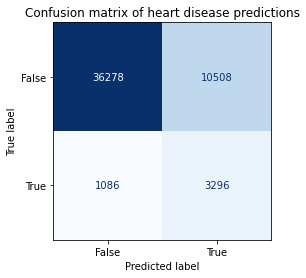

In [80]:
# Plot confusion matrix
plot_confusion_matrix_from_predictions(
    y_true=y_valid, 
    predictions=predictions, 
    normalize=None
)

By prioritizing recall, we sacrificed the model's precision. Although the model has a substantially higher false positive rate, the model was able to correctly classify substantially more individuals with history of heart disease.

In [81]:
# Recall score
print("Recall:", round(recall_score(y_true=y_valid, y_pred=predictions), 3))

Recall: 0.752


In [82]:
# Precision score
print("Precision:", round(precision_score(y_true=y_valid, y_pred=predictions), 3))

Precision: 0.239


In [83]:
# F1 score
print("F1:", round(f1_score(y_true=y_valid, y_pred=predictions), 3))

F1: 0.362


In [84]:
# Accuracy score
print("Accuracy:", round(accuracy_score(y_true=y_valid, y_pred=predictions), 3))

Accuracy: 0.773


We could attempt to improve performance by fitting the model to resampled data. We will use synthetic minority over-sampling to create more samples of individuals classified as having history of heart disease. Conversely, we could also under-sample the majority class (individuals without history of heart disease) to balance our data set.

In [85]:
# Resample data 
sm = SMOTE(random_state=1)
X_train_scaled_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

In [86]:
# Fit logistic regression to resampled training data
fitted_lr = lr.fit(X_train_scaled_res, y_train_res)

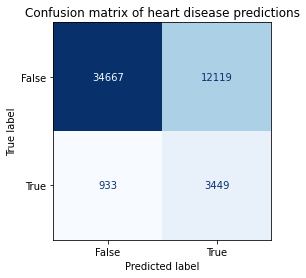

In [87]:
# Create confusion matrix of logistic regression predictions
plot_confusion_matrix_from_estimator(
    estimator=fitted_lr,
    X=X_valid_scaled, 
    y=y_valid,
    normalize=None
)

Without adjusting the decision threshold value, we see that the new model is much better at classifying individuals with history of heart disease. The model is able to correctly classify around 79% of individuals with history of heart disease.

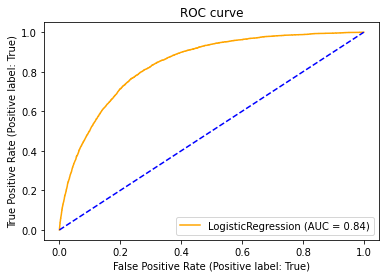

In [88]:
# Plot ROC curve of logistic regression
plot_roc_curve_from_estimator(
    estimator=fitted_lr,
    X=X_valid_scaled, 
    y=y_valid
)

The new model has a nearly identical ROC curve to the prior model.

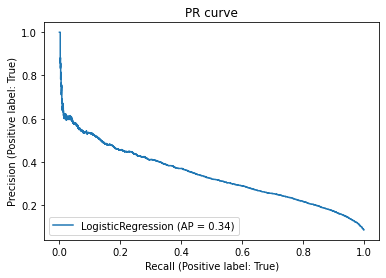

In [89]:
# Plot PR curve of logistic regression
plot_pr_curve_from_estimator(
    estimator=fitted_lr,
    X=X_valid_scaled, 
    y=y_valid,
)

The new model has a nearly identical PR curve to the prior model.

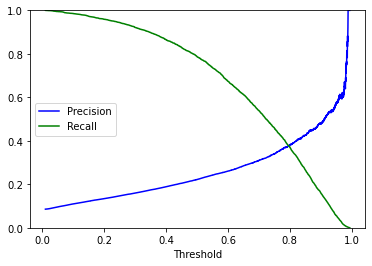

In [90]:
# Plot precision and recall with varying thresholds
plot_precision_recall_vs_threshold(estimator=fitted_lr, X=X_valid_scaled, y=y_valid)

We will use the default threshold of 0.5. As before, if we care about maximizing both recall and precision, we can choose a threshold where the various precision values and recall values intersect.

In [91]:
# Format predictions based on chosen threshold
positive_class_probabilities = fitted_lr.predict_proba(X_valid_scaled)[:, 1]
predictions = np.where(positive_class_probabilities >= 0.5, 1, 0)

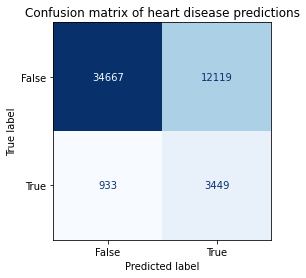

In [92]:
# Plot confusion matrix
plot_confusion_matrix_from_predictions(
    y_true=y_valid, 
    predictions=predictions, 
    normalize=None
)

In [93]:
# Recall score
print("Recall:", round(recall_score(y_true=y_valid, y_pred=predictions), 3))

Recall: 0.787


In [94]:
# Precision score
print("Precision:", round(precision_score(y_true=y_valid, y_pred=predictions), 3))

Precision: 0.222


In [95]:
# F1 score
print("F1:", round(f1_score(y_true=y_valid, y_pred=predictions), 3))

F1: 0.346


In [96]:
# Accuracy score
print("Accuracy:", round(accuracy_score(y_true=y_valid, y_pred=predictions), 3))

Accuracy: 0.745


##### Logistic regression model metrics

We will now evaluate the performance of our tuned model using our test data.

In [97]:
# Fit logistic regression to validation data
fitted_lr = lr.fit(X_train_scaled_res, y_train_res)

In [98]:
# Format predictions based on chosen threshold
positive_class_probabilities = fitted_lr.predict_proba(X_test_scaled)[:, 1]
predictions = np.where(positive_class_probabilities >= 0.5, 1, 0)

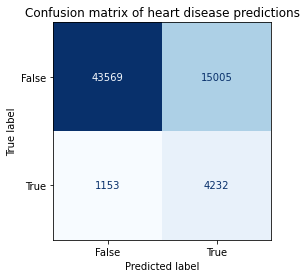

In [99]:
# Plot confusion matrix
plot_confusion_matrix_from_predictions(
    y_true=y_test, 
    predictions=predictions, 
    normalize=None
)

In [100]:
# Recall score
print("Recall:", round(recall_score(y_true=y_test, y_pred=predictions), 3))

Recall: 0.786


In [101]:
# Precision score
print("Precision:", round(precision_score(y_true=y_test, y_pred=predictions), 3))

Precision: 0.22


In [102]:
# F1 score
print("F1:", round(f1_score(y_true=y_test, y_pred=predictions), 3))

F1: 0.344


In [103]:
# Accuracy score
print("Accuracy:", round(accuracy_score(y_true=y_test, y_pred=predictions), 3))

Accuracy: 0.747


In [104]:
# Top features for predicting history of heart disease
print(label_coefficients(coefficients=fitted_lr.coef_[0, :], X=X).head(10))

AgeCategory_80 or older    0.430657
AgeCategory_75-79          0.324562
AgeCategory_70-74          0.323624
GenHealth_Fair             0.277184
GenHealth_Poor             0.248118
AgeCategory_65-69          0.232422
Stroke                     0.227247
Smoking                    0.216036
Sex_Male                   0.192527
GenHealth_Good             0.158604
dtype: float64


##### Create decision tree model

In [105]:
# Create decision tree classifier
dtc = DecisionTreeClassifier()

##### Tuning decision tree model

We can tune the performance of the decision tree classifier by adjusting some of the `DecisionTreeClassifier()` parameters.

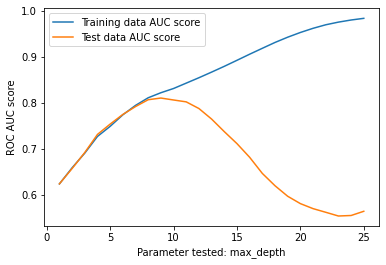

In [106]:
# Compare ROC AUC scores of varying max depth values
plot_decision_tree_roc_auc(
    X_train=X_train_scaled, 
    y_train=y_train,
    X_test=X_valid_scaled,
    y_test=y_valid,
    parameter_name="max_depth", 
    parameter_values=[*range(1, 26)],
)

The `max_depth` parameter allows the user to determine the maximum depth of the decision tree. We can see that increasing the max depth can increase ROC AUC to a point. As max depth increases, we can see the model begin to overfit to the training data.

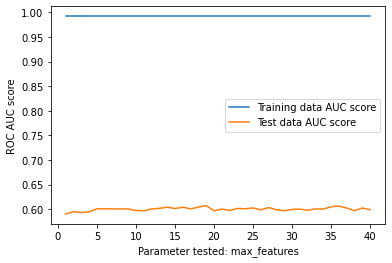

In [107]:
# Compare ROC AUC scores of varying max feature values
plot_decision_tree_roc_auc(
    X_train=X_train_scaled, 
    y_train=y_train,
    X_test=X_valid_scaled,
    y_test=y_valid,
    parameter_name="max_features", 
    parameter_values=list(range(1, X_train.shape[1])),
)

The `max_features` parameter allows the user to determine the number of features to consider when looking for the best split. We can see that choosing a value for this parameter is not likely to affect ROC AUC.

In [108]:
# Create decision tree classifer
dtc = DecisionTreeClassifier(max_depth=10)

We created a new decision tree classifier based on our analysis of the parameters above.

In [109]:
# Fit decision tree classifier
fitted_dtc = dtc.fit(X_train_scaled, y_train)

After fitting our decision tree classifier, we can analyze the model's performance using confusion matrices, ROC curves, and PR curves to determine the ideal decision threshold value for identifying individuals with history of heart disease.

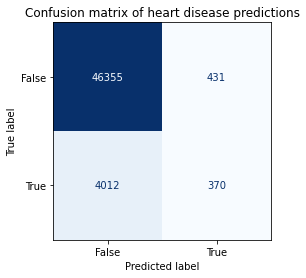

In [110]:
# Create confusion matrix of decision tree classifier predictions
plot_confusion_matrix_from_estimator(
    estimator=fitted_dtc,
    X=X_valid_scaled, 
    y=y_valid,
    normalize=None
)

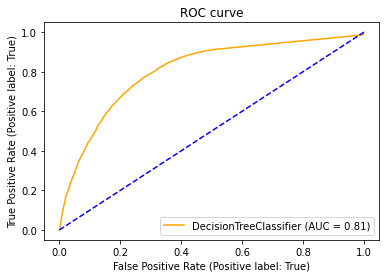

In [111]:
# Plot ROC curve of decision tree classifier
plot_roc_curve_from_estimator(
    estimator=fitted_dtc,
    X=X_valid_scaled, 
    y=y_valid
)

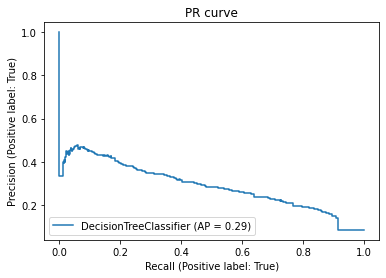

In [112]:
# Plot PR curve of decision tree classifier
plot_pr_curve_from_estimator(
    estimator=fitted_dtc,
    X=X_valid_scaled, 
    y=y_valid
)

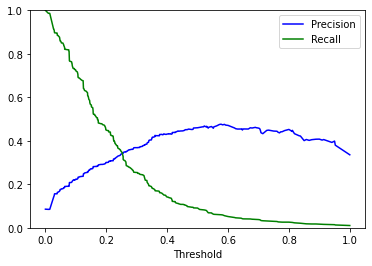

In [113]:
# Plot precision and recall with varying thresholds
plot_precision_recall_vs_threshold(estimator=fitted_dtc, X=X_valid_scaled, y=y_valid)

In [114]:
# Format predictions based on chosen threshold
positive_class_probabilities = fitted_dtc.predict_proba(X_valid_scaled)[:, 1]
predictions = np.where(positive_class_probabilities >= 0.1, 1, 0)

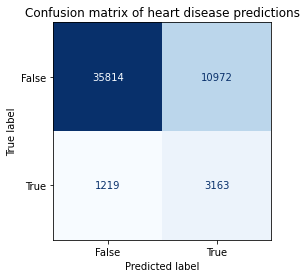

In [115]:
# Plot confusion matrix
plot_confusion_matrix_from_predictions(
    y_true=y_valid, 
    predictions=predictions, 
    normalize=None
)

In [116]:
# Recall score
print("Recall:", round(recall_score(y_true=y_valid, y_pred=predictions), 3))

Recall: 0.722


In [117]:
# Precision score
print("Precision:", round(precision_score(y_true=y_valid, y_pred=predictions), 3))

Precision: 0.224


In [118]:
# F1 score
print("F1:", round(f1_score(y_true=y_valid, y_pred=predictions), 3))

F1: 0.342


In [119]:
# Accuracy score
print("Accuracy:", round(accuracy_score(y_true=y_valid, y_pred=predictions), 3))

Accuracy: 0.762


We could attempt to improve performance by fitting the model to resampled data. As with the logistic regression model, we used synthetic minority oversampling to create more samples of individuals classified as having history of heart disease. 

In [120]:
# Fit decision tree classifer to resampled training data
fitted_dtc = dtc.fit(X_train_scaled_res, y_train_res)

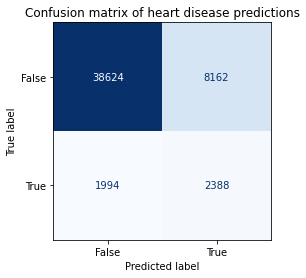

In [121]:
# Create confusion matrix of decision tree classifer predictions
plot_confusion_matrix_from_estimator(
    estimator=fitted_dtc,
    X=X_valid_scaled, 
    y=y_valid,
    normalize=None
)

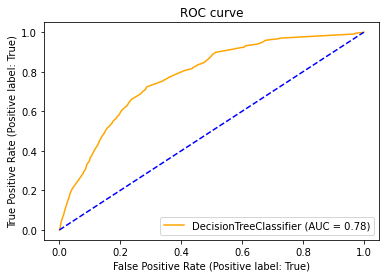

In [122]:
# Plot ROC curve of decision tree classifer
plot_roc_curve_from_estimator(
    estimator=fitted_dtc,
    X=X_valid_scaled, 
    y=y_valid
)

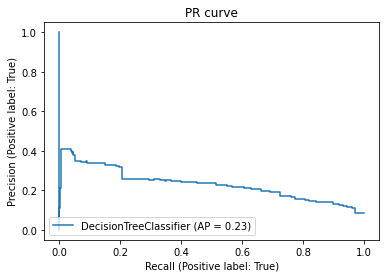

In [123]:
# Plot PR curve of decision tree classifer
plot_pr_curve_from_estimator(
    estimator=fitted_dtc,
    X=X_valid_scaled, 
    y=y_valid
)

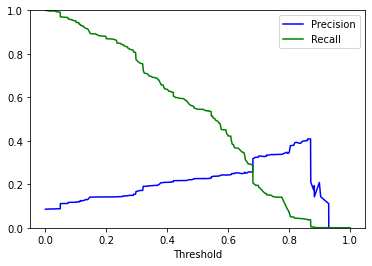

In [124]:
# Plot precision and recall with varying thresholds
plot_precision_recall_vs_threshold(estimator=fitted_dtc, X=X_valid_scaled, y=y_valid)

In [125]:
# Format predictions based on chosen threshold
positive_class_probabilities = fitted_dtc.predict_proba(X_valid_scaled)[:, 1]
predictions = np.where(positive_class_probabilities >= 0.5, 1, 0)

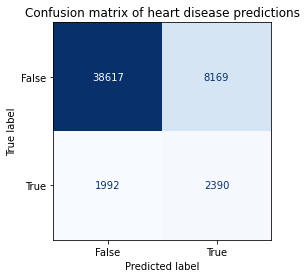

In [126]:
# Plot confusion matrix
plot_confusion_matrix_from_predictions(
    y_true=y_valid, 
    predictions=predictions, 
    normalize=None
)

In [127]:
# Recall score
print("Recall:", round(recall_score(y_true=y_valid, y_pred=predictions), 3))

Recall: 0.545


In [128]:
# Precision score
print("Precision:", round(precision_score(y_true=y_valid, y_pred=predictions), 3))

Precision: 0.226


In [129]:
# F1 score
print("F1:", round(f1_score(y_true=y_valid, y_pred=predictions), 3))

F1: 0.32


In [130]:
# Accuracy score
print("Accuracy:", round(accuracy_score(y_true=y_valid, y_pred=predictions), 3))

Accuracy: 0.801


##### Decision tree model metrics

We will now evaluate the performance of our tuned model using our test data.

In [131]:
# Fit decision tree classifier to validation data
fitted_dtc = dtc.fit(X_train_scaled, y_train)

In [132]:
# Format predictions based on chosen threshold
positive_class_probabilities = fitted_dtc.predict_proba(X_test_scaled)[:, 1]
predictions = np.where(positive_class_probabilities >= 0.1, 1, 0)

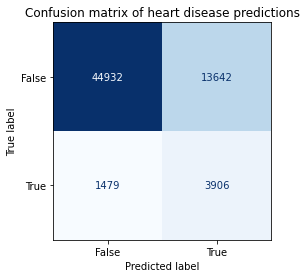

In [133]:
# Plot confusion matrix
plot_confusion_matrix_from_predictions(
    y_true=y_test, 
    predictions=predictions, 
    normalize=None
)

In [134]:
# Recall score
print("Recall:", round(recall_score(y_true=y_test, y_pred=predictions), 3))

Recall: 0.725


In [135]:
# Precision score
print("Precision:", round(precision_score(y_true=y_test, y_pred=predictions), 3))

Precision: 0.223


In [136]:
# F1 score
print("F1:", round(f1_score(y_true=y_test, y_pred=predictions), 3))

F1: 0.341


In [137]:
# Accuracy score
print("Accuracy:", round(accuracy_score(y_true=y_test, y_pred=predictions), 3))

Accuracy: 0.764


In [138]:
# Top features for predicting history of heart disease
print(label_coefficients(coefficients=fitted_dtc.feature_importances_, X=X).head(10))

DiffWalking                0.212010
Stroke                     0.148466
Diabetic                   0.068685
AgeCategory_80 or older    0.067893
GenHealth_Poor             0.046961
Sex_Female                 0.044291
GenHealth_Fair             0.041163
AgeCategory_75-79          0.037919
AgeCategory_70-74          0.037173
SleepTime                  0.032793
dtype: float64
